# Section 0 : Imports and libraries

In [ ]:
# imports used
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# our imports
import scipy.io as sio
import torch
from torch import nn
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F

# Section 1 : Loading data

In [ ]:
# mount google drive
drive.mount('/content/drive')
who = "pol"
if(who == "pol"):
  data_path = '/content/drive/My Drive/DeepLearning_2023/Projecte_Final/data/'
  results_path = ''
elif(who == "raimon"):
  data_path = '/content/drive/My Drive/'
  results_path = ''

# importing all stock prices from the csv file
df = pd.read_csv(data_path + 'ibm.csv', index_col = 0)
total_rows, total_cols = df.shape

print('\ntotal number of stocks in the dataframe :', total_rows)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

total number of stocks in the dataframe : 216883


In [ ]:
# we convert the index of the dataframe to datetime format
df.index = pd.to_datetime(df.index)

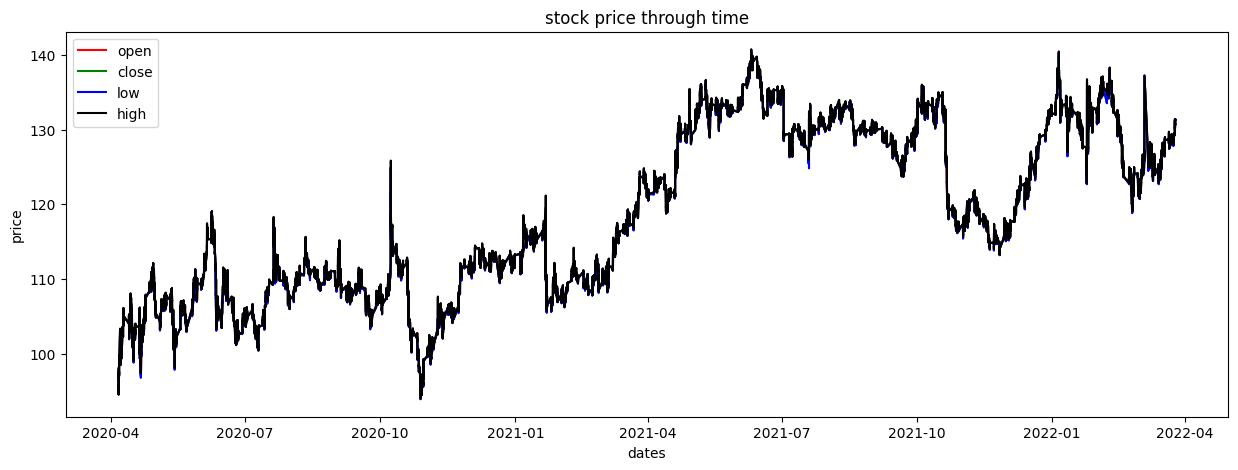

In [ ]:
plt.figure(figsize=(15, 5));
dates= df.index
plt.plot(dates, df.open.values, color='red', label='open')
plt.plot(dates, df.close.values, color='green', label='close')
plt.plot(dates, df.low.values, color='blue', label='low')
plt.plot(dates, df.high.values, color='black', label='high')
plt.title('stock price through time')
plt.xlabel('dates')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

# Section 2 : Manipulating the stocks

In [ ]:
# split data in 80%/20% train/test sets
test_set_size_percentage = 20

# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))

    return df

# normalizing stocks
df=df.drop(['volume'], axis=1)
df = df.sort_index(ascending=True)
df_stock_norm = df.copy()
df_stock_norm = normalize_data(df_stock_norm)

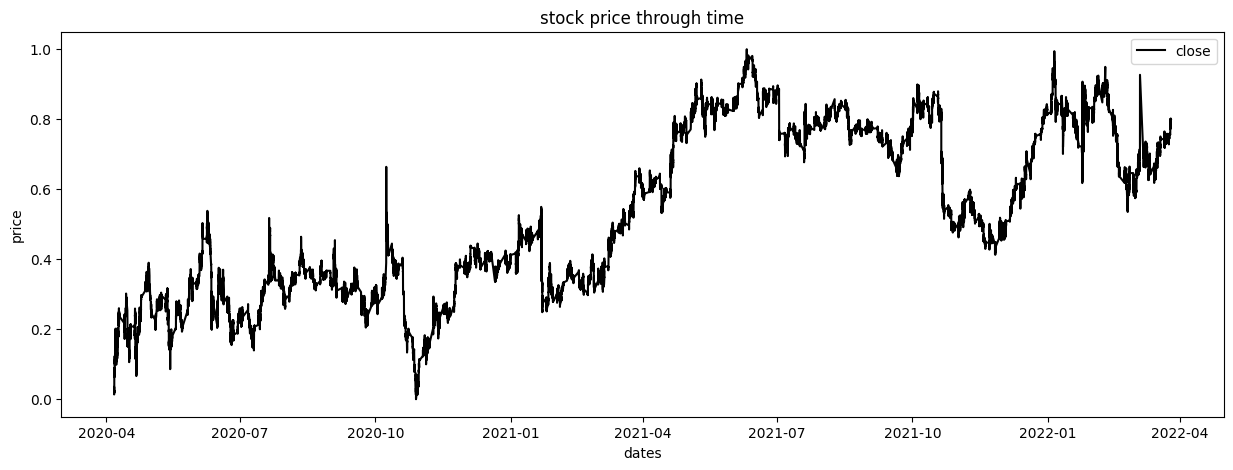

In [ ]:
# printing now the normalized stocks, but only the close value since is the one that we are interested in
plt.figure(figsize=(15, 5));
dates= df_stock_norm.index
plt.plot(dates, df_stock_norm.close.values, color='black', label='close')
plt.title('stock price through time')
plt.xlabel('dates')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

# Section 3 : Modeling and testing

In [ ]:
# dataloader of the model
class stockDL(nn.Module):
  def __init__(self,
               n_inputs,
               n_neurons,
               n_outputs,
               n_layers,
               n_model = 1):
    super().__init__()

    self.n_inputs = n_inputs
    self.n_neurons = n_neurons
    self.n_outputs = n_outputs
    self.n_layers = n_layers

    # we proceed to define the architecture that we will use
    self.n_model = n_model
    if self.n_model == 1:
      self.rnn = nn.RNN(input_size = n_inputs, hidden_size = n_neurons, num_layers = n_layers, batch_first=True)
    elif self.n_model == 2:
      self.rnn = nn.LSTM(input_size = n_inputs, hidden_size = n_neurons, num_layers = n_layers, batch_first=True)
    elif self.n_model == 3:
      self.rnn = nn.GRU(input_size = n_inputs, hidden_size = n_neurons, num_layers = n_layers, batch_first=True)
    else:
      self.rnn = nn.RNN(input_size = n_inputs, hidden_size = n_neurons, num_layers = n_layers, batch_first=True)

    self.fc = nn.Linear(n_neurons, n_outputs)

  def forward(self, X):
    output, _ = self.rnn(X)
    output = self.fc(output[:, -1, :])  # Take the output of the last time step
    return output

In [ ]:
def train_stocks(X_train, Y_train, stockModel, optimizer, loss_func, epochs=100):
    loss_its = []
    for iter in range(epochs):
        optimizer.zero_grad()
        output = stockModel(X_train)
        loss = loss_func(output, Y_train)
        if iter % 10 == 0 and iter !=0:
            print("epoch ", iter, "MSE : ", loss.item())
        loss_its.append(loss.item())
        loss.backward()
        optimizer.step()
    print(f'final loss : {loss.item()}')
    return np.asarray(loss_its)

#this function changes depending on the section objective
def test_stocks(X_test, Y_test, stockModel, prob_threshold=0.5):
    output = stockModel(X_test)
    testScore = math.sqrt(F.mse_loss(Y_test[:,3], output[:,3]))
    print('test Score : %.4f RMSE' % (testScore))
    return testScore, output

## Section 3.1 : Short sequence length

In [ ]:
# we create the test, validation and training sets using stock data and sequence length
seq_len = 20
stock = df_stock_norm
data_raw = stock.to_numpy() # convert to numpy array
data = []

for index in range(len(data_raw) - seq_len):
    data.append(data_raw[index: index + seq_len])

data = np.array(data)
test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]))
train_set_size = data.shape[0] - (test_set_size)

x_train = torch.from_numpy(data[:train_set_size,:-1,:]).double()
y_train = torch.from_numpy(data[:train_set_size,-1,:]).double()

x_test = torch.from_numpy(data[train_set_size:,:-1,:]).double()
y_test = torch.from_numpy(data[train_set_size:,-1,:]).double()

### Section 3.1.1 : Studying RNNs

In [ ]:
# define MSE loss
loss_func = nn.MSELoss()

# parameters that will remain constant
n_epochs = 100
n_inputs = 4
n_outputs = 4
n_mod = 1

#parameters that will be modified
n_layers = [2,2,2,2,3,3,3,3,4,4,4,4]
n_neurons = [6,6,8,8,6,6,8,8,6,6,8,8]
learning_rate = [0.1,0.01,0.1,0.01,0.1,0.01,0.1,0.01,0.1,0.01,0.1,0.01]

losses_models = {}
test_score = {}
pred = {}

for neurons, layers, lrates in zip(n_neurons,n_layers,learning_rate):
  model_id = f'NL{layers}_NN{neurons}_LR{lrates}'
  print(f'Training: {model_id}')
  stockModel = stockDL(n_inputs, neurons, n_outputs, layers, n_mod)
  optimizer = torch.optim.Adam(stockModel.parameters(), lr=lrates)
  losses_models[model_id] = train_stocks(x_train, y_train,
                            stockModel.double(), optimizer,
                            loss_func, epochs=n_epochs)
  test_score[model_id], pred[model_id] = test_stocks(x_test, y_test, stockModel)

In [ ]:
for loss_it in losses_models.values():
  plt.plot(loss_it)
plt.legend(losses_models.keys())
plt.show()

pd.DataFrame(np.asarray(list(test_score.values())), columns=['RMSE'],
             index=test_score.keys()).transpose()

min_RNN_short = min(test_score, key=lambda x: test_score[x])
least_RMSE_RNN_short = test_score[min_RNN_short]
least_loss_RNN_short = losses_models[min_RNN_short]
least_pred_RNN_short = pred[min_RNN_short]
print('the model with least RMSE is', min_RNN_short, 'having an RMSE of', least_RMSE_RNN_short, 'and a final loss of', least_loss_RNN_short[n_epochs-1])

### Section 3.1.2 : Studying LSTMs

In [ ]:
# define MSE loss
loss_func = nn.MSELoss()

# parameters that will remain constant
n_epochs = 100
n_inputs = 4
n_outputs = 4
n_mod = 2

#parameters that will be modified
n_layers = [2,2,3,3,3]
n_neurons = [8,10,2,4,5]
learning_rate = [0.01,0.1,0.1,0.1,0.1]

losses_models = {}
test_score = {}
pred = {}

for neurons, layers, lrates in zip(n_neurons,n_layers,learning_rate):
  model_id = f'NL{layers}_NN{neurons}_LR{lrates}'
  print(f'Training: {model_id}')
  stockModel = stockDL(n_inputs, neurons, n_outputs, layers, n_mod)
  optimizer = torch.optim.Adam(stockModel.parameters(), lr=lrates)
  losses_models[model_id] = train_stocks(x_train, y_train,
                            stockModel.double(), optimizer,
                            loss_func, epochs=n_epochs)
  test_score[model_id], pred[model_id] = test_stocks(x_test, y_test, stockModel)

In [ ]:
for loss_it in losses_models.values():
  plt.plot(loss_it)
plt.legend(losses_models.keys())
plt.show()

pd.DataFrame(np.asarray(list(test_score.values())), columns=['RMSE'],
             index=test_score.keys()).transpose()

min_LSTM_short = min(test_score, key=lambda x: test_score[x])
least_RMSE_LSTM_short = test_score[min_LSTM_short]
least_loss_LSTM_short = losses_models[min_LSTM_short]
least_pred_LSTM_short = pred[min_LSTM_short]
print('the model with least RMSE is', min_LSTM_short, 'having an RMSE of', least_RMSE_LSTM_short, 'and a final loss of', least_loss_LSTM_short[n_epochs-1])

### Section 3.1.3 : Studying GRUs

In [ ]:
# define MSE loss
loss_func = nn.MSELoss()

# parameters that will remain constant
n_epochs = 100
n_inputs = 4
n_outputs = 4
n_mod = 3

#parameters that will be modified
n_layers = [2,2,3,3,3,4]
n_neurons = [8,10,2,4,5,2]
learning_rate = [0.01,0.1,0.1,0.1,0.1,0.1]

losses_models = {}
test_score = {}
pred = {}

for neurons, layers, lrates in zip(n_neurons,n_layers,learning_rate):
  model_id = f'NL{layers}_NN{neurons}_LR{lrates}'
  print(f'Training: {model_id}')
  stockModel = stockDL(n_inputs, neurons, n_outputs, layers, n_mod)
  optimizer = torch.optim.Adam(stockModel.parameters(), lr=lrates)
  losses_models[model_id] = train_stocks(x_train, y_train,
                            stockModel.double(), optimizer,
                            loss_func, epochs=n_epochs)
  test_score[model_id], pred[model_id] = test_stocks(x_test, y_test, stockModel)

In [ ]:
for loss_it in losses_models.values():
  plt.plot(loss_it)
plt.legend(losses_models.keys())
plt.show()

pd.DataFrame(np.asarray(list(test_score.values())), columns=['RMSE'],
             index=test_score.keys()).transpose()

min_GRU_short = min(test_score, key=lambda x: test_score[x])
least_RMSE_GRU_short = test_score[min_GRU_short]
least_loss_GRU_short = losses_models[min_GRU_short]
least_pred_GRU_short = pred[min_GRU_short]
print('the model with least RMSE is', min_GRU_short, 'having an RMSE of', least_RMSE_GRU_short, 'and a final loss of', least_loss_GRU_short[n_epochs-1])

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

#CLOSE
df1 = df[['close']]
axes.plot(df1[len(df1)-len(y_test):].index, y_test[:,3], color = 'red', label = 'Real IBM Stock Price')
axes.plot(df1[len(df1)-len(y_test):].index, pred[model_id][:,3].detach().numpy(), color = 'blue', label = 'Predicted IBM Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price at close')
plt.legend()
#plt.savefig('ibm_pred.png')
plt.show()

In [ ]:
plt.figure(figsize=(15, 5));
dates= df.index
#plt.plot(dates, df.open.values, color='red', label='open')
plt.plot(pred[model_id][:,3].detach().numpy(), color='blue', label='pred')
plt.plot(y_test[:,3], color='red', label='y_test')
#plt.plot(dates, df.high.values, color='black', label='high')
plt.title('stock price through time')
plt.xlabel('Timestep')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

## Section 3.2 : Long sequence length

In [ ]:
# we create the test, validation and training sets using stock data and sequence length
seq_len = 40
stock = df_stock_norm
data_raw = stock.to_numpy() # convert to numpy array
data = []

for index in range(len(data_raw) - seq_len):
    data.append(data_raw[index: index + seq_len])

data = np.array(data)
test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]))
train_set_size = data.shape[0] - (test_set_size)

x_train = torch.from_numpy(data[:train_set_size,:-1,:]).double()
y_train = torch.from_numpy(data[:train_set_size,-1,:]).double()

x_test = torch.from_numpy(data[train_set_size:,:-1,:]).double()
y_test = torch.from_numpy(data[train_set_size:,-1,:]).double()

### Section 3.2.1 : Studying RNNs

In [ ]:
# define MSE loss
loss_func = nn.MSELoss()

# parameters that will remain constant
n_epochs = 100
n_inputs = 4
n_outputs = 4
n_mod = 1

#parameters that will be modified
n_layers = [2,2,2,2,3,3,3,3,4,4,4,4]
n_neurons = [6,6,8,8,6,6,8,8,6,6,8,8]
learning_rate = [0.1,0.01,0.1,0.01,0.1,0.01,0.1,0.01,0.1,0.01,0.1,0.01]

losses_models = {}
test_score = {}
pred = {}

for neurons, layers, lrates in zip(n_neurons,n_layers,learning_rate):
  model_id = f'NL{layers}_NN{neurons}_LR{lrates}'
  print(f'Training: {model_id}')
  stockModel = stockDL(n_inputs, neurons, n_outputs, layers, n_mod)
  optimizer = torch.optim.Adam(stockModel.parameters(), lr=lrates)
  losses_models[model_id] = train_stocks(x_train, y_train,
                            stockModel.double(), optimizer,
                            loss_func, epochs=n_epochs)
  test_score[model_id], pred[model_id] = test_stocks(x_test, y_test, stockModel)

In [ ]:
for loss_it in losses_models.values():
  plt.plot(loss_it)
plt.legend(losses_models.keys())
plt.show()

pd.DataFrame(np.asarray(list(test_score.values())), columns=['RMSE'],
             index=test_score.keys()).transpose()

min_RNN_long = min(test_score, key=lambda x: test_score[x])
least_RMSE_RNN_long = test_score[min_RNN_long]
least_loss_RNN_long = losses_models[min_RNN_long]
least_pred_RNN_long = pred[min_RNN_long]
print('the model with least RMSE is', min_RNN_long, 'having an RMSE of', least_RMSE_RNN_long, 'and a final loss of', least_loss_RNN_long[n_epochs-1])

### Section 3.2.3: Studying LSTMs

In [ ]:
# define MSE loss
loss_func = nn.MSELoss()

# parameters that will remain constant
n_epochs = 100
n_inputs = 4
n_outputs = 4
n_mod = 2

#parameters that will be modified
n_layers = [2,2,3,3,3,4]
n_neurons = [8,10,2,4,5,2]
learning_rate = [0.01,0.1,0.1,0.1,0.1,0.1]

losses_models = {}
test_score = {}
pred = {}

for neurons, layers, lrates in zip(n_neurons,n_layers,learning_rate):
  model_id = f'NL{layers}_NN{neurons}_LR{lrates}'
  print(f'Training: {model_id}')
  stockModel = stockDL(n_inputs, neurons, n_outputs, layers, n_mod)
  optimizer = torch.optim.Adam(stockModel.parameters(), lr=lrates)
  losses_models[model_id] = train_stocks(x_train, y_train,
                            stockModel.double(), optimizer,
                            loss_func, epochs=n_epochs)
  test_score[model_id], pred[model_id] = test_stocks(x_test, y_test, stockModel)

Training: NL2_NN8_LR0.1


In [ ]:
for loss_it in losses_models.values():
  plt.plot(loss_it)
plt.legend(losses_models.keys())
plt.show()

pd.DataFrame(np.asarray(list(test_score.values())), columns=['RMSE'],
             index=test_score.keys()).transpose()

min_LSTM_long = min(test_score, key=lambda x: test_score[x])
least_RMSE_LSTM_long = test_score[min_LSTM_long]
least_loss_LSTM_long = losses_models[min_LSTM_long]
least_pred_LSTM_long = pred[min_LSTM_long]
print('the model with least RMSE is', min_LSTM_long, 'having an RMSE of', least_RMSE_LSTM_long, 'and a final loss of', least_loss_LSTM_long[n_epochs-1])

### Section 3.2.3 : Studying GRUs

In [ ]:
# define MSE loss
loss_func = nn.MSELoss()

# parameters that will remain constant
n_epochs = 100
n_inputs = 4
n_outputs = 4
n_mod = 3

#parameters that will be modified
n_layers = [2,3,3,3,4]
n_neurons = [8,2,4,5,2]
learning_rate = [0.01,0.1,0.1,0.1,0.1]

#losses_models = {}
test_score = {}
pred = {}

for neurons, layers, lrates in zip(n_neurons,n_layers,learning_rate):
  model_id = f'NL{layers}_NN{neurons}_LR{lrates}'
  print(f'Training: {model_id}')
  stockModel = stockDL(n_inputs, neurons, n_outputs, layers, n_mod)
  optimizer = torch.optim.Adam(stockModel.parameters(), lr=lrates)
  losses_models[model_id] = train_stocks(x_train, y_train,
                            stockModel.double(), optimizer,
                            loss_func, epochs=n_epochs)
  test_score[model_id], pred[model_id] = test_stocks(x_test, y_test, stockModel)

In [ ]:
for loss_it in losses_models.values():
  plt.plot(loss_it)
plt.legend(losses_models.keys())
plt.show()

pd.DataFrame(np.asarray(list(test_score.values())), columns=['RMSE'],
             index=test_score.keys()).transpose()

min_GRU_long = min(test_score, key=lambda x: test_score[x])
least_RMSE_GRU_long = test_score[min_GRU_long]
least_loss_GRU_long = losses_models[min_GRU_long]
least_pred_GRU_long = pred[min_GRU_long]
print('the model with least RMSE is', min_GRU_long, 'having an RMSE of', least_RMSE_GRU_long, 'and a final loss of', least_loss_GRU_long[n_epochs-1])

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

#CLOSE
df1 = df[['close']]
axes.plot(df1[len(df1)-len(y_test):].index, y_test[:,3], color = 'red', label = 'Real IBM Stock Price')
axes.plot(df1[len(df1)-len(y_test):].index, pred[model_id][:,3].detach().numpy(), color = 'blue', label = 'Predicted IBM Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price at close')
plt.legend()
#plt.savefig('ibm_pred.png')
plt.show()

# Section 4 : Different inputs for predicting the stocks

In [ ]:
# we create the test, validation and training sets using stock data and sequence length
seq_len = 20
stock = df_stock_norm
data_raw = stock.to_numpy() # convert to numpy array
data = []

for index in range(len(data_raw) - seq_len):
    data.append(data_raw[index: index + seq_len])

data = np.array(data)
test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]))
train_set_size = data.shape[0] - (test_set_size)

x_train = torch.from_numpy(data[:train_set_size,:-1,:]).double()
y_train = torch.from_numpy(data[:train_set_size,-1,:]).double()

x_test = torch.from_numpy(data[train_set_size:,:-1,:]).double()
y_test = torch.from_numpy(data[train_set_size:,-1,:]).double()

In [ ]:
def test_stocks(X_test, Y_test, stockModel, prob_threshold=0.5):
    output = stockModel(X_test)
    print(Y_test.shape, output[:,-1].shape)
    testScore = math.sqrt(F.mse_loss(Y_test, output[:,-1]))
    print('test Score : %.4f RMSE' % (testScore))
    return testScore, output

In [ ]:
# define MSE loss
loss_func = nn.MSELoss()

# parameters that will remain constant
n_epochs = 100
n_inputs = 3
n_outputs = 3
n_mod = 3

#parameters that will be modified
n_layers = [3]
n_neurons = [5]
learning_rate = [0.1]

losses_models = {}
test_score = {}
pred = {}

for neurons, layers, lrates in zip(n_neurons,n_layers,learning_rate):
  model_id = f'NL{layers}_NN{neurons}_LR{lrates}'
  print(f'Training: {model_id}')
  stockModel = stockDL(n_inputs, neurons, n_outputs, layers, n_mod)
  optimizer = torch.optim.Adam(stockModel.parameters(), lr=lrates)
  losses_models[model_id] = train_stocks(x_train[:,:,4-n_inputs:4], y_train[:,4-n_inputs:4],
                            stockModel.double(), optimizer,
                            loss_func, epochs=n_epochs)
  test_score[model_id], pred[model_id] = test_stocks(x_test[:,:,4-n_inputs:4], y_test[:,3], stockModel)

Training: NL3_NN5_LR0.1
epoch  10 MSE :  0.01315961301536269
epoch  20 MSE :  0.004195368179932285
epoch  30 MSE :  0.00204265478273335
epoch  40 MSE :  0.0007324815430268994
epoch  50 MSE :  0.00024196628417343563
epoch  60 MSE :  8.889022697103786e-05
epoch  70 MSE :  4.4428262247795e-05
epoch  80 MSE :  2.9616883542132407e-05
epoch  90 MSE :  1.877176765216435e-05
final loss : 0.00022272025512461765
torch.Size([43373]) torch.Size([43373])
test Score : 0.0074 RMSE


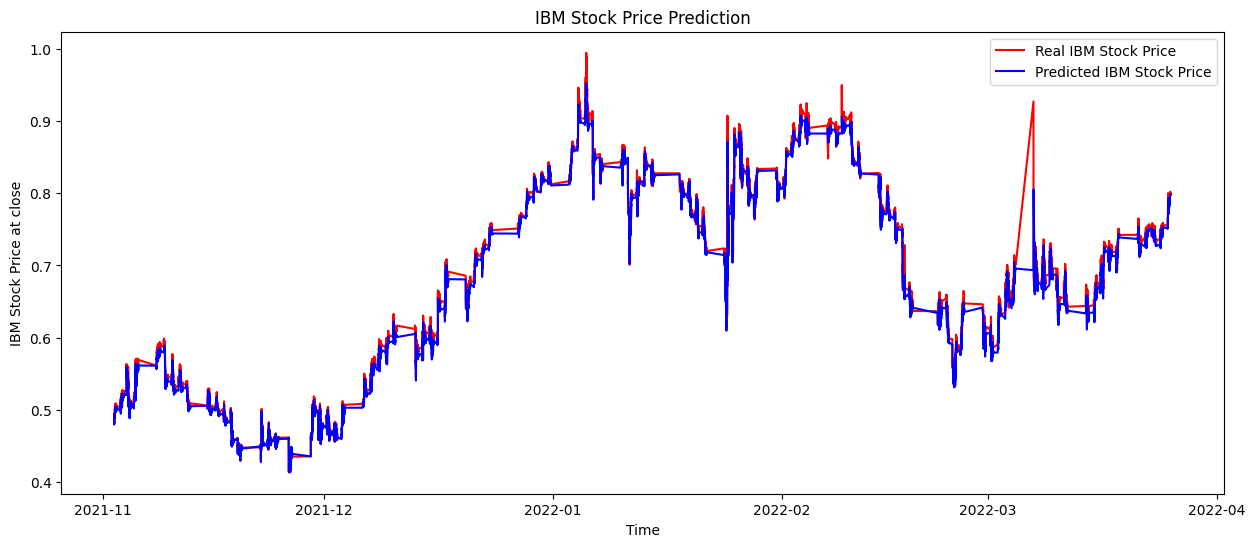

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

#CLOSE
df1 = df[['close']]
axes.plot(df1[len(df1)-len(y_test):].index, y_test[:,3], color = 'red', label = 'Real IBM Stock Price')
axes.plot(df1[len(df1)-len(y_test):].index, pred[model_id][:,-1].detach().numpy(), color = 'blue', label = 'Predicted IBM Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price at close')
plt.legend()
#plt.savefig('ibm_pred.png')
plt.show()

# Section 5: Predicting consecutive Stock values


In [ ]:
class stockDL2(nn.Module):
  def __init__(self,
               n_inputs,
               n_neurons,
               n_outputs,
               n_layers,
               n_model = 1):
    super().__init__()

    self.n_inputs = n_inputs
    self.n_neurons = n_neurons
    self.n_outputs = n_outputs
    self.n_layers = n_layers

    # we proceed to define the architecture that we will use
    self.n_model = n_model
    if self.n_model == 1:
      self.rnn = nn.RNN(input_size = n_inputs, hidden_size = n_neurons, num_layers = n_layers, batch_first=True)
    elif self.n_model == 2:
      self.rnn = nn.LSTM(input_size = n_inputs, hidden_size = n_neurons, num_layers = n_layers, batch_first=True)
    elif self.n_model == 3:
      self.rnn = nn.GRU(input_size = n_inputs, hidden_size = n_neurons, num_layers = n_layers, batch_first=True)
    else:
      self.rnn = nn.RNN(input_size = n_inputs, hidden_size = n_neurons, num_layers = n_layers, batch_first=True)

    self.fc = nn.Linear(n_neurons, n_outputs)

  def forward(self, X):
    output, _ = self.rnn(X)
    output = self.fc(output[:, -2:, :])  # Take the output of the last time step
    return output

In [ ]:
def train_stocks(X_train, Y_train, stockModel, optimizer, loss_func, epochs=100):
    loss_its = []
    for iter in range(epochs):
        optimizer.zero_grad()
        output = stockModel(X_train)

        loss = loss_func(output, Y_train)
        if iter % 10 == 0 and iter !=0:
            print("epoch ", iter, "MSE : ", loss.item())
        loss_its.append(loss.item())
        loss.backward()
        optimizer.step()
    print(f'final loss : {loss.item()}')
    return np.asarray(loss_its)

In [ ]:
#this function changes depending on the section objective
def test_stocks(X_test, Y_test, stockModel, prob_threshold=0.5):
    output = stockModel(X_test)

    testScore = math.sqrt(F.mse_loss(Y_test, output))
    print('test Score : %.4f RMSE' % (testScore))
    return testScore, output

In [ ]:
seq_len = 20
stock = df_stock_norm
data_raw = stock.to_numpy() # convert to numpy array
data = []

for index in range(len(data_raw) - seq_len):
    data.append(data_raw[index: index + seq_len])

data = np.array(data)
test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]))
train_set_size = data.shape[0] - (test_set_size)

x_train = torch.from_numpy(data[:train_set_size,:-1,:]).double()
y_train = torch.from_numpy(data[:train_set_size,-1,:]).double()

x_train2 = torch.from_numpy(data[:train_set_size,:-2,:]).double()
y_train2 = torch.from_numpy(data[:train_set_size,-2:,:]).double()

x_test = torch.from_numpy(data[train_set_size:,:-1,:]).double()
y_test = torch.from_numpy(data[train_set_size:,-1,:]).double()

x_test2 = torch.from_numpy(data[train_set_size:,:-2,:]).double()
y_test2 = torch.from_numpy(data[train_set_size:,-2:,:]).double()

In [ ]:
# define MSE loss
loss_func = nn.MSELoss()

# parameters that will remain constant
n_epochs = 100
n_inputs = 4
n_outputs = 4
n_mod = 3

#parameters that will be modified
n_layers = [3]
n_neurons = [5]
learning_rate = [0.1]

losses_models = {}
test_score = {}
pred = {}

for neurons, layers, lrates in zip(n_neurons,n_layers,learning_rate):
  model_id = f'NL{layers}_NN{neurons}_LR{lrates}'
  print(f'Training: {model_id}')
  stockModel = stockDL2(n_inputs, neurons, n_outputs, layers, n_mod)
  optimizer = torch.optim.Adam(stockModel.parameters(), lr=lrates)
  losses_models[model_id] = train_stocks(x_train2[:,:,4-n_inputs:4], y_train2[:,:,4-n_inputs:4],
                            stockModel.double(), optimizer,
                            loss_func, epochs=n_epochs)
  test_score[model_id], pred[model_id] = test_stocks(x_test2[:,:,4-n_inputs:4], y_test2[:,:,3:4], stockModel)

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

#CLOSE
df1 = df[['close']]
axes.plot(df1[len(df1)-len(y_test2):].index, y_test2[:,0,3], color = 'red', label = 'Real IBM Stock Price 1st')

axes.plot(df1[len(df1)-len(y_test2):].index, pred[model_id][:,0,3].detach().numpy(), color = 'blue', label = 'Predicted IBM Stock Price 1st')

#axes.xticks(np.arange(0,394,50))
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price at close')
plt.legend()
#plt.savefig('ibm_pred.png')
plt.show()

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

#CLOSE
df1 = df[['close']]

axes.plot(df1[len(df1)-len(y_test2):].index, y_test2[:,1,3], color = 'orange', label = 'Real IBM Stock Price 2nd')

axes.plot(df1[len(df1)-len(y_test2):].index, pred[model_id][:,1,3].detach().numpy(), color = 'purple', label = 'Predicted IBM Stock Price 2nd')
#axes.xticks(np.arange(0,394,50))
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price at close')
plt.legend()
#plt.savefig('ibm_pred.png')
plt.show()

# Section 6 : Introducing a new dataset

In [ ]:
# importing all stock prices from the new csv file
new_df = pd.read_csv(data_path + 'CISCO.csv', index_col = 0)
new_total_rows, new_total_cols = new_df.shape

print('\ntotal number of stocks in the dataframe :', new_total_rows)

# adapting the new database
new_df.drop(columns=['Adj Close', 'Volume'])
new_df.index = pd.to_datetime(new_df.index)
new_df = new_df.rename(columns={'Open': 'open', 'High': 'high', 'Close': 'close', 'Low': 'low'})

# normalizing stocks
new_df_stock_norm = new_df.copy()
new_df_stock_norm = normalize_data(new_df_stock_norm)




total number of stocks in the dataframe : 8186


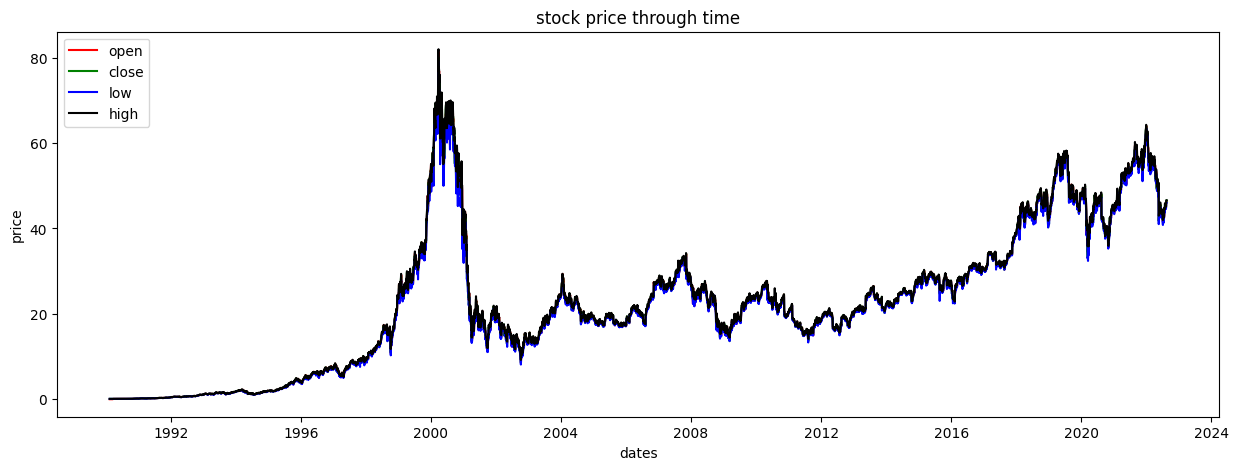

In [ ]:
plt.figure(figsize=(15, 5));
dates= new_df.index
plt.plot(dates, new_df.open.values, color='red', label='open')
plt.plot(dates, new_df.close.values, color='green', label='close')
plt.plot(dates, new_df.low.values, color='blue', label='low')
plt.plot(dates, new_df.high.values, color='black', label='high')
plt.title('stock price through time')
plt.xlabel('dates')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

In [ ]:
# we create the test, validation and training sets using stock data and sequence length
seq_len = 20
stock = new_df_stock_norm
data_raw = stock.to_numpy() # convert to numpy array
data = []

for index in range(len(data_raw) - seq_len):
    data.append(data_raw[index: index + seq_len])

data = np.array(data)
test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]))
train_set_size = data.shape[0] - (test_set_size)

new_x_test = torch.from_numpy(data[:,:-1,:]).double()
new_y_test = torch.from_numpy(data[:,-1,:]).double()

In [ ]:
#We choose our best model
# define MSE loss
loss_func = nn.MSELoss()

# parameters that will remain constant
n_epochs = 100
n_inputs = 4
n_outputs = 4
n_mod = 3

#parameters that will be modified
n_layers = [3]
n_neurons = [5]
learning_rate = [0.1]

losses_models = {}
test_score = {}
pred = {}

for neurons, layers, lrates in zip(n_neurons,n_layers,learning_rate):
  model_id = f'NL{layers}_NN{neurons}_LR{lrates}'
  print(f'Training: {model_id}')
  stockModel = stockDL(n_inputs, neurons, n_outputs, layers, n_mod)
  optimizer = torch.optim.Adam(stockModel.parameters(), lr=lrates)
  losses_models[model_id] = train_stocks(x_train, y_train,
                            stockModel.double(), optimizer,
                            loss_func, epochs=n_epochs)



Training: NL3_NN5_LR0.1
epoch  10 MSE :  0.02017878749010005
epoch  20 MSE :  0.013129256200333788
epoch  30 MSE :  0.0029245196002118928
epoch  40 MSE :  0.002160336615395362
epoch  50 MSE :  0.000876956631311132
epoch  60 MSE :  0.0005147420209326368
epoch  70 MSE :  0.0002862999274908556
epoch  80 MSE :  0.00016201485470441663
epoch  90 MSE :  0.00010974353565082282
final loss : 8.405031209370836e-05


In [ ]:
def test_stocks(X_test, Y_test, stockModel, prob_threshold=0.5):
    output = stockModel(X_test)

    testScore = math.sqrt(F.mse_loss(Y_test, output[:,3]))
    print('test Score : %.4f RMSE' % (testScore))
    return testScore, output

In [ ]:
test_score[model_id], pred[model_id] = test_stocks(new_x_test[:,:,4-n_inputs:4], new_y_test[:,3], stockModel)

test Score : 0.0179 RMSE


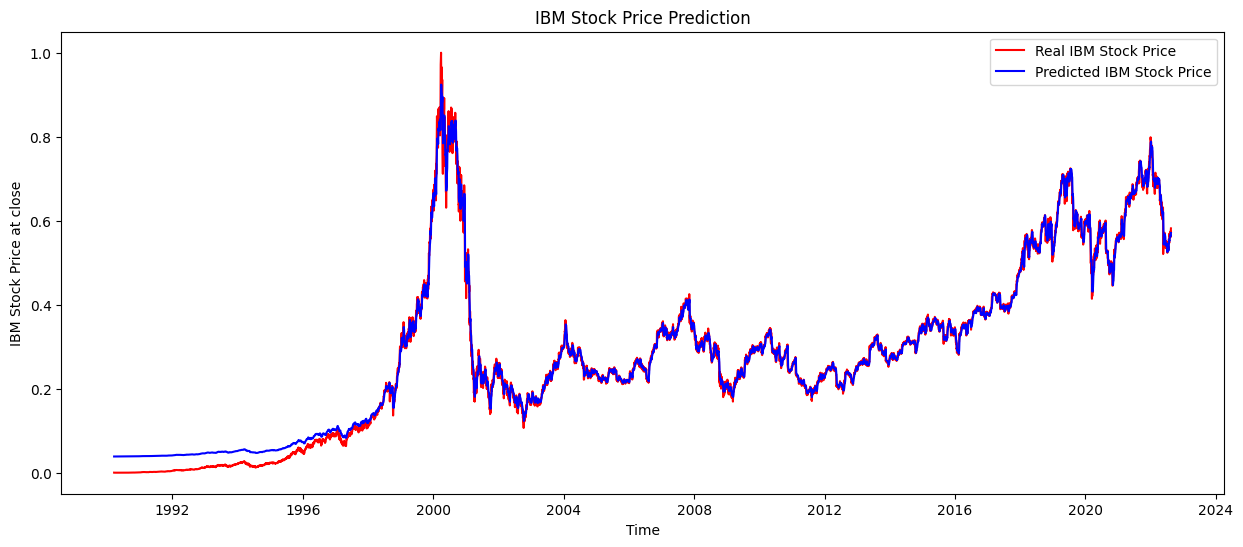

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

#CLOSE
df1 = new_df_stock_norm[['close']]
axes.plot(df1[len(df1)-len(new_y_test):].index, new_y_test[:,3], color = 'red', label = 'Real IBM Stock Price')
axes.plot(df1[len(df1)-len(new_y_test):].index, pred[model_id][:,-1].detach().numpy(), color = 'blue', label = 'Predicted IBM Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price at close')
plt.legend()
#plt.savefig('ibm_pred.png')
plt.show()